# Create NIRCam TSO Simulated Data

This notebook shows how to run [Mirage](https://mirage-data-simulator.readthedocs.io/en/latest/) to create TSO data.

It uses an xml and a pointing file exported from an [APT](https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview) file for a proposal containing both Grism and Imaging mode time series observations. From these files, along with several other user-inputs, Mirage will create a series of input yaml files. One yaml file is produced for each detector in each exposure. Mirage then creates the simulated data corresponding to each yaml file.

Note that in a TSO exposure, users will typically get data from 3 [detectors](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview) (A1 and A3 for shortwave data, and A5 for longwave data) in each exposure.

In this example, we will use an example APT program that looks at WASP-79. The proposal contains 3 observations:

* Grism TSO - F444W, with accompanying Weak Lens +8 and F182M shortwave imaging observation
* Grism TSO - F322W2, with accompanying Weak Lens +8 and F210M shortwave imaging observation
* Imaging TSO - F470N in the longwave channel, and Weak Lens +8 and F210M in the shortwave channel

We will create yaml files for all of these observations (including the accompanying Target Acquisition exposures). We will then use Mirage to create simulated data for both longwave Grism Time Series observations, as well as one of the Imaging observations that accompany the Grism data. 

## Table of Contents

* [Imports](#imports)
* [Inputs](#inputs)
  * [Stellar Spectrum](#stellar_spectrum)
  * [Batman parameters](#batman_parameters)
  * [Transmission Spectrum - needed for GrTSO](#transmission_spectrum)
  * [Grism TSO catalog](#grism_tso_catalog)
  * [Lightcurve File - needed for Imaging TSO](#lightcurve_file)
  * [Imaging TSO catalog](#imaging_tso_catalog)
  * [Catalog of Background Sources](#background_catalog)
  * [Create Input Yaml Files](#yaml_files)
* [Create Simulated Data](#create_simulated_data)
  * [Grism TSO](#grism_data)
  * [Imaging TSO](#imaging_data)
* [Run Calibration Pipeline](#calibration_pipeline)

<a id="imports"></a>
## Imports

In [1]:
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.visualization import simple_norm, imshow_norm
from astropy import units as u
import batman
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import stsynphot as stsyn
from synphot import SourceSpectrum, SpectralElement
from synphot import units
import yaml

from mirage.catalogs.hdf5_catalog import save_tso
from mirage.catalogs.catalog_generator import GrismTSOCatalog, ImagingTSOCatalog, PointSourceCatalog
from mirage.catalogs.catalog_generator import TSO_GRISM_INDEX
from mirage.grism_tso_simulator import GrismTSO
from mirage.imaging_simulator import ImgSim
from mirage.seed_image.catalog_seed_image import Catalog_seed
from mirage.yaml import yaml_generator

Function for viewing simulated data

In [2]:
def show(array, title, min=0, max=1000):
    fig, ax = plt.subplots(figsize=(10, 10))
    norm = simple_norm(array, stretch='log', min_cut=min, max_cut=max)
    cax = ax.imshow(array, norm=norm, origin='lower')
    cbar = fig.colorbar(cax)
    plt.title(title)
    plt.show()

<a id="prepare_inputs"></a>
## Prepare Inputs

Prior to simulated data creation, there are a number of input parameters to set and files to be created. To start with, define the xml and pointing files associated with the APT file. These files can be saved from within APT by selecting them from table that appears when you select **Export** from the **File** menu. 

In [3]:
xml_file = 'wasp-79_example_TSO.xml'
pointing_file = xml_file.replace('.xml', '.pointing')

<a id="stellar_spectrum"></a>
### Stellar spectrum

This is the spectrum of the unocculted star associated with the TSO object. For this example, we'll use the Castelli & Kurucz models in stsynphot to generate a spectrum that is similar to WASP-79. You can generate your spectrum using any tool you like, as it will eventually be saved in an hdf5 file below.

In [4]:
t_eff = 6750  # surface temperature
metallicity = 0.03
log_g = 4.26  # surface gravity = 182 m/s^2
sp = stsyn.grid_to_spec('ck04models', t_eff, metallicity, log_g) 

Normalize the spectrum to be k = 9.06. There are two ways you can scale your spectrum. This first is shown here, where you manually scale the spectrum before saving to the hdf5 file. The second way is to leave the scaling to Mirage. In that case, you save the spectrum as-is, and set the flux units in the hdf5 file to 'normalized'. With that option, Mirage will automatically scale the spectrum to the magnitude indicated in the grism TSO source catalog. If you choose to scale the spectrum manually (and use flux units of 'flam' in the hdf5 file), then Mirage will ignore the source magnitude listed in the grism TSO catalog, and use the saved spectrum with no changes.

In [5]:
# Normalize the spectrum
bp = SpectralElement.from_filter('johnson_k')
vega = SourceSpectrum.from_vega()
sp_norm = sp.normalize(9.06 * units.VEGAMAG, bp, vegaspec=vega)

Get wavelengths and flux densities of the spectrum

In [6]:
wavelengths = sp_norm.waveset.to(u.micron)
fluxes = sp_norm(wavelengths, flux_unit='flam')

Examine the spectrum in the wavelengths of interest

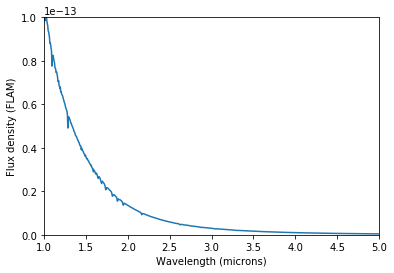

In [7]:
f, a = plt.subplots()
a.plot(wavelengths, fluxes)
a.set_xlim(1, 5)
a.set_ylim(0, 1e-13)
a.set_xlabel('Wavelength (microns)')
a.set_ylabel('Flux density (FLAM)')
plt.show()

Set the units for the wavelength and flux density arrays. It's generally recommended to use flux denisty units of FLAM (). 

In [8]:
wavelength_units = 'microns'
flux_units = 'flam'
#flux_units = 'normalized'

Name of the file in which to save the spectrum

In [9]:
sed_file = 'test_grism_tso_sed_file_wasp79.hdf5'

HDF5 files can contain multiple datasets, so make the flux and wavelength variables into lists, even though for TSO observations there will be only one source.

In [10]:
fluxes = [fluxes]
wavelengths = [wavelengths]

Save the spectrum in the hdf5 file. Give the dataset a unique index number.

In [11]:
with h5py.File(sed_file, "w") as file_obj:
    for i in range(len(fluxes)):
        dset = file_obj.create_dataset(str(i+TSO_GRISM_INDEX), data=[wavelengths[i].value, fluxes[i].value],
                                       dtype='f', compression="gzip", compression_opts=9)
        dset.attrs[u'wavelength_units'] = wavelength_units
        dset.attrs[u'flux_units'] = flux_units

<a id="batman_parameters"></a>
### Batman Parameters

Model lightcurves are generated using the Batman (INSERT LINK) package. Here, set the parameters that Batman needs. See the Batman documentation for details.

In [12]:
# In this case, we'll use parameters based on WASP-79b, but modified for a shorter exposure time
# and a deeper eclipse, in order to save processing time and make the resulting data easier to
# examine.
params = batman.TransitParams()       # object to store transit parameters 
params.t0 = 280.                        # time of inferior conjunction 
params.per = 3162.24                       # orbital period 
params.rp = 0.723                       # planet radius (in units of stellar radii) 
params.a = 9.37                        # semi-major axis (in units of stellar radii) 
params.inc = 83.3                      # orbital inclination (in degrees) 
params.ecc = 0.                       # eccentricity 
params.w = 90.                        # longitude of periastron (in degrees) 
params.limb_dark = "nonlinear"        # limb darkening model 
params.u = [0.5, 0.1, 0.1, -0.1]      # limb darkening coefficients [u1, u2, u3, u4] 

Generate the array of times at which the lightcurve will be calculated. In this case we know that the total exposure time is about 570 seconds, so we extend the array of times just beyond that range.

In [13]:
times = np.linspace(0, 580, 1000)  # times at which to calculate light curve 

<a id="transmission_spectrum"></a>
### Create a Transmission Spectrum

The transmission spectrum is the wavelength-dependent effective radius of the planet, in units of the stellar radius. It must be saved in an ascii file, and will be used in the creation of the Grism TSO data. For this example, we use the simple case of a flat spectrum. 

In [14]:
waves = np.linspace(0.9, 5.5, 1000)  # microns
trans = np.repeat(params.rp, 1000)  # R_planet / R_star

In [15]:
tran_spec_file = 'transmission_spectrum.txt'
tab = Table()
tab['Wavelength'] = waves
tab['Transmission'] = trans
tab.write(tran_spec_file, format='ascii', overwrite=True)

Plot transmission spectrum

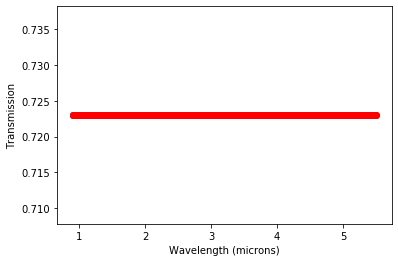

In [16]:
f, a = plt.subplots()
a.scatter(waves, trans, color='red', marker='o')
a.set_xlabel('Wavelength (microns)')
a.set_ylabel('Transmission')
plt.show()

<a id="grism_tso_catalog"></a>
### Create Grism TSO catalog

With the stellar spectrum and transmission spectrum saved, we can now create the Grism TSO source catalog that Mirage will use when creating the simulated data.

In [17]:
# Name of catalog file to hold information on the TSO source
grism_tso_catalog = 'tso_grism_source.cat'

Basic information on the source. Note that the object magnitude will be ignored if the saved stellar spectrum is in units of FLAM. Conversely, if the stellar spectrum has units of 'normalized', then Mirage will scale the spectrum to the magnitude indicated below.

In [18]:
object_ra = 66.37083
object_dec = -30.60056
object_f444w_mag = 9.0

Create the Grism TSO catalog object and populate RA, Dec, Batman parameters, times, and the name of the transmission spectrum file.

In [19]:
grism_cat = GrismTSOCatalog(ra=[object_ra], dec=[object_dec], semimajor_axis=[params.a],
                            orbital_inclination=[params.inc], eccentricity=[params.ecc],
                            orbital_period=[params.per], longitude_of_periastron=[params.w],
                            limb_dark_model=[params.limb_dark], limb_dark_coeffs=[params.u],
                            time_units=['second'], start_time=[np.min(times)],
                            end_time=[np.max(times)], inferior_conj=[params.t0],
                            transmission_spectrum=[tran_spec_file])

Add the source magnitudes to the catalog

In [20]:
# Add source magnitude
grism_cat.add_magnitude_column([object_f444w_mag], magnitude_system='vegamag',
                               instrument='nircam', filter_name='f444w')

In [21]:
grism_cat.save(grism_tso_catalog)

Examine the contents of the catalog. There should be only a single source.

In [22]:
grism_cat.table

index,x_or_RA,y_or_Dec,Semimajor_axis_in_stellar_radii,Orbital_inclination_deg,Eccentricity,Longitude_of_periastron,Limb_darkening_model,Limb_darkening_coeffs,Time_units,Start_time,End_time,Time_of_inferior_conjunction,Orbital_period,Transmission_spectrum,nircam_f444w_magnitude
int64,float64,float64,float64,float64,float64,float64,str9,str19,str6,float64,float64,float64,float64,str25,float64
99999,66.37083,-30.60056,9.37,83.3,0.0,90.0,nonlinear,"0.5, 0.1, 0.1, -0.1",second,0.0,580.0,280.0,3162.24,transmission_spectrum.txt,9.0


<a id="lightcurve_file"></a>
### Create Lightcurve File

For the imaging time series observations, we need to provide a file that contains the lightcurve to use when simulating the data.

Initialize the batman model using the parameters specified in the [Batman Parameters](batman_parameters) section and generate a lightcurve.

In [23]:
m = batman.TransitModel(params, times)
flux = m.light_curve(params)

Plot the lightcurve to be used to generate the data

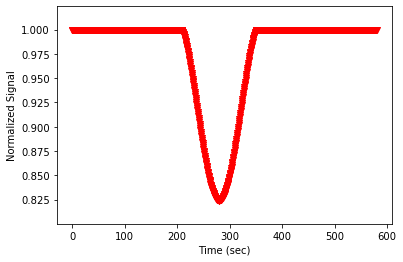

In [24]:
f, a = plt.subplots()
a.scatter(times, flux, color='red', marker='v')
a.set_xlabel('Time (sec)')
a.set_ylabel('Normalized Signal')
plt.show()

In [25]:
lightcurve_file = 'example_lightcurve.hdf5'

Place the lightcurve into a dictionary to prepare for saving. The keys are object indexes corresponding to objects in the Mirage input catalogs. 

In [26]:
contents = {}
contents['1'] = {'times': times,
                 'fluxes': flux}

In [27]:
# Save
save_tso(contents, lightcurve_file, time_unit='second')

<a id="imaging_tso_catalog"></a>
### Create Imaging TSO catalog

In this case, rather than the `tso_grism_catalog` in the yaml file, the user must supply a `tso_imaging_catalog`. This catalog will contain the list of sources whose flux will be varying with time. As in the grism TSO case, objects listed in the other types of catalogs will be added to the simulation in order to create a more realistic scene.

See the [notebook on catalog creation](https://github.com/spacetelescope/mirage/blob/master/examples/Catalog_Generation_Tools.ipynb) in the examples directory of the Mirage repository for examples of how to create source catalogs. Catalogs may also be created manually.

Mirage does not yet support the use of input spectra in order to determine filter-based magnitudes for imaging simulations. Until that ability is added, users must estimate the source magnitude in each filter.

In [28]:
imaging_tso_catalog = 'tso_imaging_source.cat'

In [29]:
tsimg_cat = ImagingTSOCatalog(ra=[object_ra], dec=[object_dec], lightcurve_file=[lightcurve_file])

In [30]:
object_f182m_mag = 10.0
object_f210m_mag = 9.5
object_f470n_mag = 9.0 

In [31]:
# Add source magnitudes
tsimg_cat.add_magnitude_column([object_f182m_mag], magnitude_system='vegamag',
                               instrument='nircam', filter_name='f182m')
tsimg_cat.add_magnitude_column([object_f210m_mag], magnitude_system='vegamag',
                               instrument='nircam', filter_name='f210m')
tsimg_cat.add_magnitude_column([object_f470n_mag], magnitude_system='vegamag',
                               instrument='nircam', filter_name='f470n')

In [32]:
tsimg_cat.save(imaging_tso_catalog)

In [33]:
tsimg_cat.table

index,x_or_RA,y_or_Dec,lightcurve_file,nircam_f182m_magnitude,nircam_f210m_magnitude,nircam_f470n_magnitude
int64,float64,float64,str23,float64,float64,float64
1,66.37083,-30.60056,example_lightcurve.hdf5,10.0,9.5,9.0


<a id="background_catalog"></a>
### Catalog of Background Sources

Create a catalog containing nearby sources. Mirage will add these to the data. This can help inform desired roll angles in order to avoid contamination.

Mirage accepts a series of ascii source catalogs. In this case, the options that can be used are:

1. Point source catalog
2. Galaxy catalog
3. Extended source catalog

The point source, galaxy, and extended source catalogs contain "background" sources. That is, sources other than the primary TSO target. All catalogs are input to Mirage as entries within the input yaml file.

See the notebook on [catalog creation](https://github.com/spacetelescope/mirage/blob/master/examples/Catalog_Generation_Tools.ipynb) in the examples directory of the Mirage repository for examples of how to create source catalogs. Catalogs may also be created manually. For this example, we will create a point source catalog with a single star.

In [34]:
bkgd_sources_ra = [66.378244]
bkgd_sources_dec = [-30.598312]
bkgd_sources_f444w_mag = [12.50]
bkgd_sources_f182m_mag = [13.75]
bkgd_sources_f210m_mag = [13.39]
bkgd_sources_f470n_mag = [12.40]

In [35]:
bkgd_cat_file = 'ptsrcs.cat'

In [36]:
bkgd_cat = PointSourceCatalog(ra=bkgd_sources_ra, dec=bkgd_sources_dec)

In [37]:
# Add source magnitudes
bkgd_cat.add_magnitude_column(bkgd_sources_f182m_mag, magnitude_system='vegamag',
                               instrument='nircam', filter_name='f182m')
bkgd_cat.add_magnitude_column(bkgd_sources_f444w_mag, magnitude_system='vegamag',
                               instrument='nircam', filter_name='f444w')
bkgd_cat.add_magnitude_column(bkgd_sources_f210m_mag, magnitude_system='vegamag',
                               instrument='nircam', filter_name='f210m')
bkgd_cat.add_magnitude_column(bkgd_sources_f470n_mag, magnitude_system='vegamag',
                               instrument='nircam', filter_name='f470n')

In [38]:
bkgd_cat.save(bkgd_cat_file)

In [39]:
bkgd_cat.table

index,x_or_RA,y_or_Dec,nircam_f182m_magnitude,nircam_f444w_magnitude,nircam_f210m_magnitude,nircam_f470n_magnitude
int64,float64,float64,float64,float64,float64,float64
1,66.378244,-30.598312,13.75,12.5,13.39,12.4


<a id="yaml_files"></a>
### Create input yaml files for Mirage

Mirage requires one input yaml file for each detector and exposure. Using the files exported from ATP combined with the various files produced above, Mirage can automatically generate all of the yaml files necessary to produce all of the data in the APT file. See the Mirage documentation on [creating yaml files from APT inputs](https://mirage-data-simulator.readthedocs.io/en/latest/yaml_generator.html) for details on the input parameters used below.

Populate the input catalog dictionary with the names of the source catalogs created above.

In [7]:
catalogs = {'WASP-79': {'point_source': bkgd_cat_file,
                        'tso_imaging_catalog': imaging_tso_catalog,
                        'tso_grism_catalog': grism_tso_catalog,
                        }
           }

Set the desired background level for the observations. Most common will to specify 'low', 'medium', or 'high'. The definitions of these three levels match those used in the ETC. Note that for the grism observations, if the `dateobs_for_background` is set to True, the background will be created based on the given observation date rather than the level given below.

In [8]:
background = 'medium'

Set the desired telescope roll angle and date for the observation. 

In [9]:
pav3 = 0.
dates = '2021-10-25'

In [10]:
yam = yaml_generator.SimInput(xml_file, pointing_file, catalogs=catalogs, verbose=True,
                              output_dir='./', simdata_output_dir='./',
                              background=background, roll_angle=pav3,
                              dates=dates, datatype='raw', dateobs_for_background=True,
                              reffile_defaults='crds')

yam.use_linearized_darks = True
yam.create_inputs()

CRDS_PATH environment variable not set. Setting to /Users/hilbert/crds_cache
target_info:
{'WASP-79': ('04:25:29.0168', '-30:36:1.61')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `GrismTSO-F444W` uses template `NircamGrismTimeSeries`
APTObservationParams Dictionary holds 0 entries before reading template
Dictionary read from template has 2 entries.
Found 0.0 tile(s) for observation 001 GrismTSO-F444W
APTObservationParams Dictionary holds 2 entries after reading template (+2 entries)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `002` labelled `GrismTSO-F322W2` uses template `NircamGrismTimeSeries`
APTObservationParams Dictionary holds 2 entries before reading template
Dictionary read from template has 2 entries.
Found 0.0 tile(s) for observation 002 GrismTSO-F322W2
APTObservationParams Dictionary holds 4 entries after reading template (

List the yaml files created by the generator

In [11]:
yam.yaml_files

['/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca5.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00002_nrca5.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca1.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca3.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888002001_01101_00001_nrca5.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888002001_01101_00002_nrca5.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888002001_01101_00001_nrca1.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888002001_01101_00001_nrca3.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888003001_01101_00001_nrcb5.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888003001_01101_00001_nrcb1.yaml',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888003001_01101_00002_nrcb5.yaml']

Create a table showing details of what exposure each yaml file describes

In [12]:
basenames = []
modes = []
apertures = []
filters = []
pupils = []
for yfile in yam.yaml_files:
    with open(yfile) as file_obj:
        info = yaml.safe_load(file_obj)
    basenames.append(os.path.basename(yfile))
    modes.append(info['Inst']['mode'])
    apertures.append(info['Readout']['array_name'])
    filters.append(info['Readout']['filter'])
    pupils.append(info['Readout']['pupil'])
info_tab = Table()
info_tab['Filename'] = basenames
info_tab['Mode'] = modes
info_tab['Aperture'] = apertures
info_tab['Filter'] = filters
info_tab['Pupil'] = pupils

Exposures using `imaging` mode are for the target acquisition exposures. Those with `ts_grism` mode describe the Grism time series observations. Those with `ts_imaging` mode are for Imaging time series observations. This includes the data collected with the shortwave channel detectors while the longwave detector is producing the grism time series observations.

In [13]:
info_tab

Filename,Mode,Aperture,Filter,Pupil
str36,str10,str21,str6,str6
jw88888001001_01101_00001_nrca5.yaml,imaging,NRCA5_TAGRISMTS32,F335M,CLEAR
jw88888001001_01101_00002_nrca5.yaml,ts_grism,NRCA5_GRISM256_F444W,F444W,GRISMR
jw88888001001_01101_00001_nrca1.yaml,ts_imaging,NRCA1_GRISMTS256,F182M,WLP8
jw88888001001_01101_00001_nrca3.yaml,ts_imaging,NRCA3_GRISMTS256,F182M,WLP8
jw88888002001_01101_00001_nrca5.yaml,imaging,NRCA5_TAGRISMTS32,F335M,CLEAR
jw88888002001_01101_00002_nrca5.yaml,ts_grism,NRCA5_GRISM256_F322W2,F322W2,GRISMR
jw88888002001_01101_00001_nrca1.yaml,ts_imaging,NRCA1_GRISMTS256,F210M,WLP8
jw88888002001_01101_00001_nrca3.yaml,ts_imaging,NRCA3_GRISMTS256,F210M,WLP8
jw88888003001_01101_00001_nrcb5.yaml,imaging,NRCB5_TAPSIMG32,F335M,CLEAR


<a id="create_simulated_data"></a>
## Create Simulated Data

Simulate data from some of the files above.

<a id="grism_data"></a>
### Grism TSO Data

First let's simulate a grism time series exposure using the F444W filter. 

In [40]:
gr_tso_yaml_file = 'jw88888001001_01101_00002_nrca5.yaml'

In [ ]:
gr_f444w = GrismTSO(gr_tso_yaml_file, SED_file=sed_file, SED_normalizing_catalog_column=None,
                    final_SED_file=None, save_dispersed_seed=True, source_stamps_file=None,
                    extrapolate_SED=True, override_dark=None, disp_seed_filename=None,
                    orders=["+1", "+2"])
gr_f444w.create()

From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_mask_0038.fits as the badpixmask reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_superbias_0022.fits as the superbias reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_linearity_0052.fits as the linearity reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_saturation_0063.fits as the saturation reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_gain_0056.fits as the gain reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_flat_0142.fits as the pixelflat reference file.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_ipc_0028.fits as the ipc reference file.
No inverted IPC kernel file found. Kernel will be inverted prior to use.
From CRDS, found /grp/crds/cache/references/jwst/jwst_nircam_distortion_0090.asdf as the astrometric reference file.
From CRDS, found /grp/crds/cache/referenc

3150it [00:13, 228.53it/s]

Computing dispersed background for order  +2
disperse_background_1D: x-direction
1448 1448



3150it [00:08, 362.74it/s]


Adding contribution from order  +1
Adding contribution from order  +2
Max signal in dispersed background img: 71.42550726742903
Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
SIAF: Requested NRCA5_GRISM256_F444W   got NRCA5_GRISM256_F444W
CAUTION: Aperture NRCA5_GRISM256_F444W can be used with either a 1-amp
or a 4-amp readout. The difference is a factor of 4 in
readout time. You have requested 4 amps.
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
output dimensions are: [ 362 2896]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Frametime is 1.3466900000000002
PSFs will be generated using: /ifs/jwst/wit/mirage_data/nircam/gridded_psf_library/nircam_nrca5_f444w_clear_fovp61_samp5_npsf16_predicted_realization0.fits
PSF wings will be from: nircam_nrca5_f444w_clear_fovp401_samp1_predicted_realization0.fits
Creating signal rate image of synthetic inputs.
Calculating point source lists
Point list input positions assumed to be in units of R

Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  28
integ and frame:  4 4
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  30
integ and frame:  5 0
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  31
integ and frame:  5 1
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  32
integ and frame:  5 2
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  33
integ and frame:  5 3
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  34
integ and frame:  5 4
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  36
integ and frame:  6 0
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  37
integ and frame:  6 1
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  38
integ and frame:  6 2
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  39
integ and frame:  6 3
Max signal in frame_

TOTAL FRAME COUNTER:  139
integ and frame:  23 1
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  140
integ and frame:  23 2
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  141
integ and frame:  23 3
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  142
integ and frame:  23 4
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  144
integ and frame:  24 0
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  145
integ and frame:  24 1
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  146
integ and frame:  24 2
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  147
integ and frame:  24 3
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  148
integ and frame:  24 4
Max signal in frame_only_signal: 727.7517087358492
TOTAL FRAME COUNTER:  150
integ and frame:  25 0
Max signal in frame_only_signal: 727.7517087358492


4.87747597694397 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.01578688621520996 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  180
integ and frame:  30 0
180 is during the transit
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
5.539580821990967 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.014753103256225586 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  181
integ and frame:  30 1
181 is during the transit
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
4.83802604675293 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.015973806381225586 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  182
integ and frame:  30 2
182 is during the transit
Dispersi

4.935218811035156 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.015608787536621094 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  207
integ and frame:  34 3
207 is during the transit
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
4.921120882034302 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.015273094177246094 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  208
integ and frame:  34 4
208 is during the transit
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
5.1422200202941895 s.
Dispersing  1 of 1 ID: 99999 from cached version
Applying a transmission function...
0.01172018051147461 s.
Adding contribution from order  +1
Adding contribution from order  +2
TOTAL FRAME COUNTER:  210
integ and frame:  35 0
210 is during the transit
Dispe

#### Examine the results

Mirage will split the exposure into mulitple files if it is too large, in the same way that the JWST calibration pipeline will do. Exposures will be split around integrations. That is, an integration will not be split between two files.

First, look at the seed image, which is the noiseless scene that contains only signal from the astronomical sources, including background.

In [16]:
gr_f444w.seed_files

['/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00002_nrca5_uncal_F444W_seg001_part001_seed_image.fits',
 '/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00002_nrca5_uncal_F444W_seg002_part001_seed_image.fits']

Read in the first seed file. Checking the array dimensions, we see that it holds the first 60 integrations.

In [21]:
data_444 = fits.getdata(gr_f444w.seed_files[0])

In [33]:
data_444.shape

(60, 5, 256, 2048)

Look at the seed image. The TSO source is the lower source of the two, as the reference location for the GRISM256 aperture is in the 35th row from the bottom.

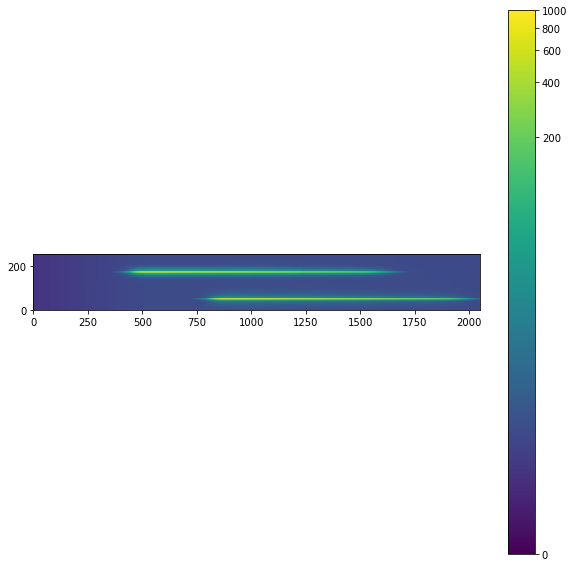

In [32]:
show(data_444[0, 4, :, :], 'F444W: Final group of integration 0')

Using the seed image, plot the signal along the trace of the TSO object for each integration, as a sanity check to see that the signal does change with time.

In [ ]:
f, a = plt.subplots()
for i in range(data.shape[0]): 
   slope_444 = data_444[i, 4, 51, 700:] 
   a.plot(np.arange(len(slope_444)), slope_444, color='blue')

Look at the raw, or uncalibrated data

In [15]:
uncal_file = 'jw88888001001_01101_00002-seg001_nrca5_uncal.fits'

In [16]:
uncal = fits.getdata(uncal_file)

Look at a difference image between the last and first groups of an integration. By using the difference, we remove bias offsets and make the sources more visible. Raw files have signals in integers, so multiply by 1.0 in order to make them floats before subtracting.

The elevated background signal in the 512-column wide area is the result of each 512-column block being read out by a different amplifier. These differences will disappear once the data have been run through the calibration pipeline.

In [17]:
diff = 1. * uncal[0, 4, :, :] - 1. * uncal[0, 0, :, :]

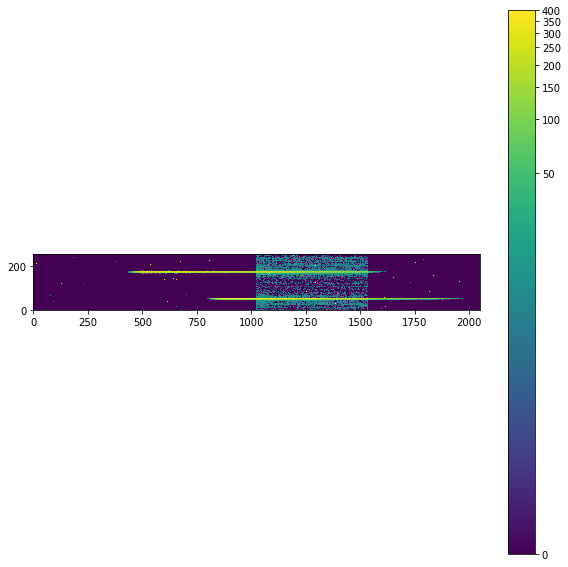

In [19]:
show(diff, "Uncalibrated Data", min=0, max=400)

Create simulated data for the same observation, but in the F322W2 filter

In [ ]:
gr_tso_f322w2_yaml_file = 'jw88888002001_01101_00002_nrca5.yaml'

In [ ]:
gr_f322w2 = GrismTSO(gr_tso_f322w2_yaml_file, SED_file=sed_file, SED_normalizing_catalog_column=None,
                     final_SED_file=None, save_dispersed_seed=True, source_stamps_file=None,
                     extrapolate_SED=True, override_dark=None, disp_seed_filename=None,
                     orders=["+1", "+2"])
gr_f322w2.create()

Read in one of the seed image files and examine the data

In [ ]:
data_322 = fits.getdata(gr_f322w.seed_files[0])

In [ ]:
show(data_322[0, 4, :, :], 'F322W2: Final group of integration 0')

Plot the signal along the trace, as with the F444W data

In [ ]:
f, a = plt.subplots()
for i in range(data.shape[0]): 
   slope_322 = data_322[i, 4, 51, 700:] 
   a.plot(np.arange(len(slope_322)), slope_322, color='blue')

<a id="imaging_data"></a>
### Imaging TSO Data

Let's look at the imaging time series data collected on one of the shortwave detectors while the grism data above was being collected in the LW channel.

In [9]:
img_tso_sw_yaml = 'jw88888001001_01101_00001_nrca1.yaml'

In [10]:
img_tso = ImgSim()
img_tso.paramfile = img_tso_sw_yaml
img_tso.create()

CRDS_PATH environment variable not set. Setting to /Users/hilbert/crds_cache
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_mask_0033.fits as the badpixmask reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0026.fits as the superbias reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits as the linearity reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0064.fits as the saturation reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_gain_0050.fits as the gain reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_flat_0348.fits as the pixelflat reference file.
From CRDS, found /Users/hilbert/crds_cache/references/jwst/nircam/jwst_nircam_ipc_0026.fits as the ipc reference file.
Found an existing inverted kernel f

0.0 297.79969353011643

Integrating lightcurve signal: 
16 16 64 [64 65 66 67 68]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
17 17 68 [68 69 70 71 72]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
18 18 72 [72 73 74 75 76]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
19 19 76 [76 77 78 79 80]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
20 20 80 [80 81 82 83 84]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.7996935

0.0 297.79969353011643

Integrating lightcurve signal: 
57 57 228 [228 229 230 231 232]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
58 58 232 [232 233 234 235 236]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
59 59 236 [236 237 238 239 240]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
60 60 240 [240 241 242 243 244]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
61 61 244 [244 245 246 247 248]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.

0.0 297.79969353011643

Integrating lightcurve signal: 
98 98 392 [392 393 394 395 396]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
99 99 396 [396 397 398 399 400]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
100 100 400 [400 401 402 403 404]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
101 101 404 [404 405 406 407 408]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
102 102 408 [408 409 410 411 412]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.

0.0 297.79969353011643

Integrating lightcurve signal: 
138 138 552 [552 553 554 555 556]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
139 139 556 [556 557 558 559 560]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
140 140 560 [560 561 562 563 564]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
141 141 564 [564 565 566 567 568]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
142 142 568 [568 569 570 571 572]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.7996935301164

0.0 297.79969353011643

Integrating lightcurve signal: 
177 177 708 [708 709 710 711 712]
0.9154839470473061
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 272.6308388624291
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
178 178 712 [712 713 714 715 716]
0.9107065062031545
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 271.2081184431825
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
179 179 716 [716 717 718 719 720]
0.9059526148469935
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 269.7924110542423
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
180 180 720 [720 721 722 723 724]
0.901234517432094
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 268.38736309003997
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
181 181 724 [724 725 726 727 728]
0.8965634917577061
0.0 221.1345547

0.0 297.79969353011643

Integrating lightcurve signal: 
215 215 860 [860 861 862 863 864]
0.8309153531353518
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 247.44633751317625
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
216 216 864 [864 865 866 867 868]
0.8328240213796421
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 248.01473833137655
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
217 217 868 [868 869 870 871 872]
0.8349505622493414
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 248.64802155065226
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
218 218 872 [872 873 874 875 876]
0.8372931720302579
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 249.34565002546984
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
219 219 876 [876 877 878 879 880]
0.8398415112230221
0.0 221.134

0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
253 253 1012 [1012 1013 1014 1015 1016]
0.9819885357541192
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 292.43588499766446
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
254 254 1016 [1016 1017 1018 1019 1020]
0.9853163327716942
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 293.42690192962874
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
255 255 1020 [1020 1021 1022 1023 1024]
0.9884096844358801
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 294.3481011072042
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
256 256 1024 [1024 1025 1026 1027 1028]
0.9912415340326038
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 295.1914250492319
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
257 257 1028 [1028 

0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
292 292 1168 [1168 1169 1170 1171 1172]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
293 293 1172 [1172 1173 1174 1175 1176]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
294 294 1176 [1176 1177 1178 1179 1180]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
295 295 1180 [1180 1181 1182 1183 1184]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
296 296 1184 [1184 1185 1186 1187 1188]
1.0
0.0 221.134554745425 (256, 2048) 

0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
331 331 1324 [1324 1325 1326 1327 1328]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
332 332 1328 [1328 1329 1330 1331 1332]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
333 333 1332 [1332 1333 1334 1335 1336]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
334 334 1336 [1336 1337 1338 1339 1340]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
335 335 1340 [1340 1341 1342 1343 1344]
1.0
0.0 221.134554745425 (256, 2048) 

0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
375 15 1500 [1500 1501 1502 1503 1504]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
376 16 1504 [1504 1505 1506 1507 1508]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
377 17 1508 [1508 1509 1510 1511 1512]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
378 18 1512 [1512 1513 1514 1515 1516]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
379 19 1516 [1516 1517 1518 1519 1520]
1.0
0.0 221.134554745425 (256, 2048) 128 1

0.0 297.79969353011643

Integrating lightcurve signal: 
415 55 1660 [1660 1661 1662 1663 1664]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
416 56 1664 [1664 1665 1666 1667 1668]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
417 57 1668 [1668 1669 1670 1671 1672]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643

Integrating lightcurve signal: 
418 58 1672 [1672 1673 1674 1675 1676]
1.0
0.0 221.134554745425 (256, 2048) 128 1024
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643
0.0 297.79969353011643



total_seed_segments-and_parts:  2
Seed image is 4D.




ADDING FILE TO SELF.SEED_FILES



Set these as the outputs of the call to add_

file number: 1
frames: [2 3 5 8 9]
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A1/Linearized_Dark_and_SBRefpix_NRCNRCA1-DARK-60091005411_1_481_SE_2016-01-09T10h56m36_uncal.fits
After data volume check:  (1, 5, 2048, 2048)
Saving 0th frame from data to the zeroframe extension
RAPID dark.
(1, 5, 2048, 2048)
(1, 2048, 2048)
(1, 5, 2048, 2048)



MMMMMMMMMMMMMMMMM
outdark shape: (1, 5, 2048, 2048)



DARK has been reordered to (1, 5, 2048, 2048) to match the input readpattern of RAPID

DARK mod.shape:  (1, 5, 2048, 2048)
(1, 5, 2048, 2048)
[0, 0, 2047, 255]


DARK mod.shape:  (1, 2048, 2048)
(1, 2048, 2048)
[0, 0, 2047, 255]

File number 1 will be used for integrations [2 3 5 8 9]
file number: 2
frames: [1]
Reading in linearized dark current ramp from /ifs/jwst/wit/mirage_data/nircam/darks/linearized/A1/Linearized_Dark_and_SBRefpix_NRCNRCA1-DARK-60091434481_1_481_SE_2016-01-09T15h50m45_uncal.fits
After data volume check:  (1, 5, 2048, 2048

    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 1:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 2:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 3:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 

    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 31:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 32:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (60, 5, 256, 2048)
Integration 33:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 25


Linear dark zeroframe shape:  (60, 256, 2048)

Simulated zeroframe shape:  (60, 256, 2048)
Adding crosstalk
Unlinearizing saturation values
Unlinearizing exposure.
Adding superbias and reference pixel signals.


Populating xref_sci in output file:
1981.62


WCS info for /Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001-seg001_nrca1_uncal.fits complete.


Final raw exposure saved to
/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001-seg001_nrca1_uncal.fits
Output name:  /Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca1_uncal.fits
first segment string:  002
Creating output file name with segment number.
sbandrefpix shape:  (10, 5, 256, 2048)

Seed files:
['/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca1_uncal_F182M_seg002_part001_seed_image.fits']
Reconstructing seed image
File:  /Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001_nrca1_uncal_F182M_seg002_part001_seed_image.fits
data shape:  (10, 5, 256, 2048)
Final seed image shape:  10 5 256 2048
data placed into integration:  0 10
                  groups:  0 5
(10, 5, 256, 2048)
(10, 5, 256, 2048)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / numbe

Integration 6:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (10, 5, 256, 2048)
Integration 7:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (10, 5, 256, 2048)
Integration 8:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 into group 4
frame_to_ramp output shape:  (5, 256, 2048)
sim_exposure shape:  (10, 5, 256, 2048)
Integration 9:
    Averaging frame 0 into group 0
    Averaging frame 1 into group 1
    Averaging frame 2 into group 2
    Averaging frame 3 into group 3
    Averaging frame 4 i

WCS info for /Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001-seg002_nrca1_uncal.fits complete.


Final raw exposure saved to
/Users/hilbert/python_repos/test_mirage_tso/jw88888001001_01101_00001-seg002_nrca1_uncal.fits
Observation generation complete.


Examine the raw output file. This is the simulated data before any calibration.

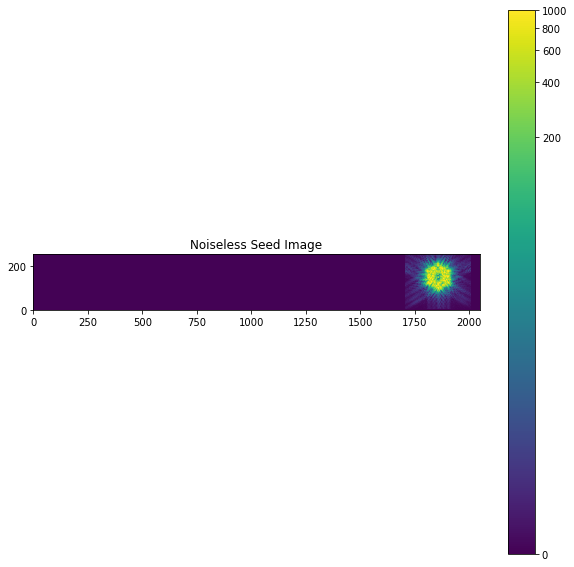

In [27]:
show(img_tso.seedimage[0, 4, :, :], 'Noiseless Seed Image')

Again, let's look at signal levels in all of the integrations, using the noiseless seed image.

In [ ]:
signals = []
cx, cy = 1857, 151
for i in range(img_tso.seedimage.shape[0]):
    signals.append(np.sum(img_tso.seedimage[i, 4, cy-15: cy+15, cx-15: cx+15]))

In [ ]:
f, a = plt.subplots()
a.plot(np.arange(len(signals)), signals, color='red')
a.set_xlabel('Integration Number')
a.set_ylabel('Aperture Signal')

In [4]:
uncal_file = 'jw88888001001_01101_00001-seg002_nrca1_uncal.fits'

In [5]:
data = fits.getdata(uncal_file)

In [6]:
data.shape

(10, 5, 256, 2048)

By displaying the difference between the last and first groups of one integration, we can remove bias signal that would otherwise make the object difficult to see.

In [12]:
cds = 1.* data[0, 4, :, :] - 1. * data[0, 0, :, :]

The image appears to have 4 512-column wide blocks because each block has been read out by a different amplifier. These differences will disappear once the data have been run through the calibration pipeline. Note that this observation was taken with one of NIRCam's weak lenses in place, which is why the star's PSF has become so large.

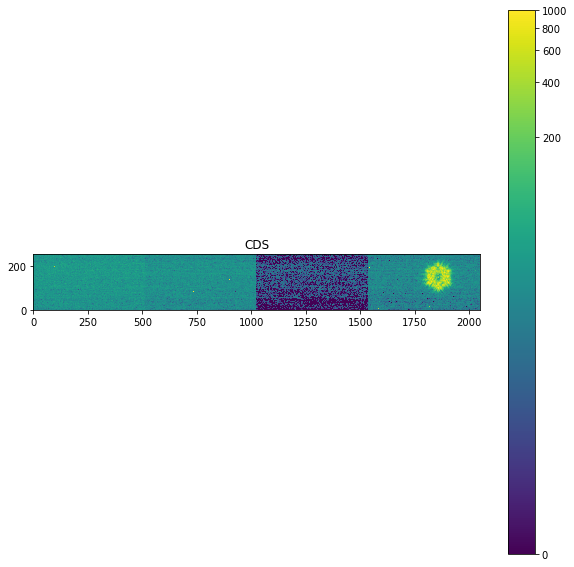

In [28]:
show(cds, 'CDS', min=0, max=1000)

<a id="calibration_pipeline"></a>
## Run the Calibration Pipeline

See the accompanying notebook for a demonstration of how to run the calibration pipeline on these data.

In [ ]:
BELOW HERE WE SHOULD BE ABLE TO REMOVE. AND THEN ADD CALIBRATION PIPELINE CELLS?

In [ ]:
m = GrismTSO(paramfile, SED_file=sed_file, SED_normalizing_catalog_column=None,
             final_SED_file=None, save_dispersed_seed=True, source_stamps_file=None,
             extrapolate_SED=True, override_dark=None, disp_seed_filename=None, orders=["+1", "+2"])
m.create()

## Imaging TSO 

1. Create lightcurve file
2. Create source catalog(s) for Mirage
3. Create an input yaml file for Mirage
4. Run Mirage

### Create lightcurve file

Use batman to create a lightcurve as save the results to an hdf5 file, which can then be input to Mirage

In [ ]:
catalog_name = 'example_lightcurve.hdf5'

Remove this cell eventually and set the paramters in the grism section above

# Batman parameters - these have been copied from the example in the Batman documentation

#params = batman.TransitParams()       # object to store transit parameters
#params.t0 = 0.                        # time of inferior conjunction
#params.per = 1.                       # orbital period
#params.rp = 0.8                       # planet radius (in units of stellar radii)
#params.a = 10.                        # semi-major axis (in units of stellar radii)
#params.inc = 87.                      # orbital inclination (in degrees)
#params.ecc = 0.                       # eccentricity
#params.w = 90.                        # longitude of periastron (in degrees)
#params.limb_dark = "nonlinear"        # limb darkening model
#params.u = [0.5, 0.1, 0.1, -0.1]      # limb darkening coefficients [u1, u2, u3, u4]

# Consistent with those in the grism data creation above
params = batman.TransitParams()       # object to store transit parameters 
params.t0 = 75.                        # time of inferior conjunction 
params.per = 300.                       # orbital period 
params.rp = 0.8                       # planet radius (in units of stellar radii) 
params.a = 4.                        # semi-major axis (in units of stellar radii) 
params.inc = 87.                      # orbital inclination (in degrees) 
params.ecc = 0.                       # eccentricity 
params.w = 90.                        # longitude of periastron (in degrees) 
params.limb_dark = "nonlinear"        # limb darkening model 
params.u = [0.5, 0.1, 0.1, -0.1]      # limb darkening coefficients [u1, u2, u3, u4] 


In [ ]:
#times = np.linspace(-0.025, 0.025, 1000)  # times at which to calculate light curve
#m = batman.TransitModel(params, times)    # initializes model
#flux = m.light_curve(params)              # calculates light curve

# Consistent with those used in the grism data above
#times = np.linspace(0, 151, 1000)  # times at which to calculate light curve 
#m = batman.TransitModel(params, times)    # initializes model 
#flux = m.light_curve(params)

In [ ]:
# Place the lightcurve into a dictionary to prepare for saving. The keys are object
# numbers corresponding to objects in the Mirage input catalogs.
#example_times = np.linspace(0, 110., 1000)

contents = {}
#contents['5'] = {'times': example_times,
#                 'fluxes': flux}
#contents['8'] = {'times': example_times,
#                 'fluxes': flux}
contents['5'] = {'times': times,
                 'fluxes': flux}

In [ ]:
# Save
save_tso(contents, catalog_name, time_unit='second')

In [ ]:
# Plot the lightcurve
f, a = plt.subplots()
a.scatter(times, flux, color='red', marker='v')
plt.show()

### Create source catalog(s) for Mirage

In this case, rather than the `tso_grism_catalog` in the yaml file, the user must supply a `tso_imaging_catalog`. This catalog will contain the list of sources whose flux will be varying with time. As in the grism TSO case, objects listed in the other types of catalogs will be added to the simulation in order to create a more realistic scene.

See the notebook on catalog creation in the examples directory of the Mirage repository for examples of how to create source catalogs. Catalogs may also be created manually.

In [ ]:



# Input cells to create Imaging mode TSO catalog
# and also ptsrcs.cat?



In [ ]:
tso_imaging_catalog = 'example_tso_sources.cat'

### Create an input yaml file for Mirage

This file contains all the inputs needed by Mirage. For most Mirage simulations, there is a tool to create these files from an APT file. However, TSO mode has not yet been added to this tool, so yaml files will have to be produced manually for the time being.

In [ ]:
imaging_yaml = 'jw_add_tso_source.yaml'

### Run Mirage

Option 1: create just the noiseless seed image. This is helpful when testing inputs, as skipping the later steps of Mirage saves significant time

In [ ]:
c = Catalog_seed()
c.paramfile = imaging_yaml
c.make_seed()

In [ ]:
test = ['jw12345001001_01101_00001_nrca1_uncal_F200W_seg001_part001_seed_image.fits',
        'jw12345001001_01101_00001_nrca1_uncal_F200W_seg002_part001_seed_image.fits']

In [ ]:
h = fits.getdata(test[1])
print(h.shape)

Option 2: Run all steps of Mirage, in order to create the final simulated data

In [ ]:
c = ImgSim()
c.paramfile = imaging_yaml
c.create()

In [ ]:
h = fits.open('jw12345001001_01101_00001_nrca1_uncal.fits')

In [ ]:
h[0].header['PATTSIZE']

In [ ]:
with fits.open('jw12345001001_01101_00001-seg001_nrca1_uncal.fits') as h:
    print(h[0].header['PATTSIZE'])
    print(h[1].data.shape)
    uncal1 = h[1].data

In [ ]:
with fits.open('jw12345001001_01101_00001-seg002_nrca1_uncal.fits') as h:
    print(h[0].header['PATTSIZE'])
    print(h[1].data.shape)
    uncal2 = h[1].data

In [ ]:
uncal1[0, :, 1024, 1026]

In [ ]:
for i in range(7):
    print(uncal1[i, :, 1021, 1026])

In [ ]:
print(uncal2[0, :, 1021, 1026])